In [1]:
import pandas as pd
import numpy as np
from numpy import array

In [2]:
#Importing dataset
df=pd.read_csv('MSFT.csv')

#Input variables
time_step = 100  # Numbers of days training to predict the next single day
node = 50 # Number of Hidden layer in LSTM 
epochs= 100 # Numbers of times go through the training dataset.

In [3]:
df1=df.reset_index()['Close']

In [4]:
df1.tail()

1253    252.750000
1254    264.600006
1255    258.350006
1256    256.769989
1257    267.559998
Name: Close, dtype: float64

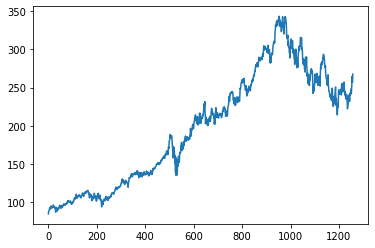

In [5]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [6]:
# MinMax Scales
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [8]:
training_size,test_size

(1006, 252)

In [9]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [10]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+n
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
print(X_train.shape), print(y_train.shape)

(905, 100)
(905,)


(None, None)

In [12]:
print(X_test.shape), print(ytest.shape)

(151, 100)
(151,)


(None, None)

In [13]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [14]:
### Create the Stacked LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [15]:
model=Sequential()
model.add(LSTM(node,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(node,return_sequences=True))
model.add(LSTM(node))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=epochs,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 10s 325ms/step - loss: 0.0485 - val_loss: 0.0224
Epoch 2/100
15/15 [==============================] - 4s 258ms/step - loss: 0.0066 - val_loss: 0.0028
Epoch 3/100
15/15 [==============================] - 3s 205ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 4/100
15/15 [==============================] - 3s 204ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 5/100
15/15 [==============================] - 4s 237ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 6/100
15/15 [==============================] - 4s 252ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 7/100
15/15 [==============================] - 3s 220ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 8/100
15/15 [==============================] - 3s 206ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 9/100
15/15 [==============================] - 4s 271ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 10/100
15/15 [==============================] - 3s 211ms/step - loss: 0.0011 - val_l

In [18]:
### Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

5/5 [==============================] - 0s 49ms/step


In [19]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [20]:
#MinMax scaler for accuracy references
New_scaler=MinMaxScaler(feature_range=(0,1))
scaled_train_predict=New_scaler.fit_transform(np.array(train_predict).reshape(-1,1))
scaled_test_predict=New_scaler.fit_transform(np.array(test_predict).reshape(-1,1))

In [21]:
# Mean Absolute Percentage Error (MAPE) performance metrics
from sklearn.metrics import mean_absolute_error
mape_train = mean_absolute_error(y_train, scaled_train_predict)*100
print(mape_train)

3.603430118839838


In [22]:
# Test Data Mean Absolute Percentage Error
mape_test = mean_absolute_error(ytest, scaled_test_predict)*100
print(mape_test)

23.91781646043008


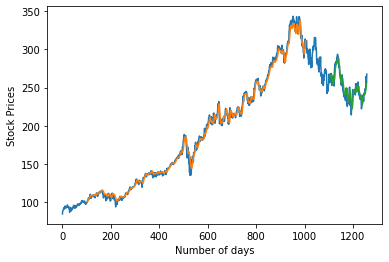

In [23]:
### Plotting 
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.ylabel('Stock Prices')
plt.xlabel('Number of days')
plt.show()

In [24]:
len(test_data)

252

In [25]:
x_input=test_data[(len(test_data) - time_step):].reshape(1,-1)
x_input.shape


(1, 100)

In [26]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [27]:
temp_input

[0.6213483671558397,
 0.6188687079456335,
 0.6180163212176577,
 0.6099961463383745,
 0.5964355100325597,
 0.6043006752154648,
 0.5924448123656016,
 0.5906238087586391,
 0.5865943896633267,
 0.6046494199110427,
 0.590817543757839,
 0.5729949699376772,
 0.6033708378818452,
 0.6349090034616547,
 0.6361488020710175,
 0.6268113198597149,
 0.5781867990281889,
 0.5588531867512754,
 0.5439752469879084,
 0.5452925504454604,
 0.5781867990281889,
 0.5561797964163369,
 0.5909337739088498,
 0.594692011273786,
 0.5868655713937029,
 0.5855869893645053,
 0.608717564309177,
 0.6285936020383233,
 0.6418055517655729,
 0.5668733616305585,
 0.5491670179614075,
 0.5845021423345076,
 0.5700116725695407,
 0.5546687540851174,
 0.5234018322271644,
 0.5007361740120688,
 0.5283998682014636,
 0.5535064022069307,
 0.5573808697228778,
 0.5404881913533485,
 0.612049610247359,
 0.6280511804605582,
 0.6065091488208273,
 0.60813641742859,
 0.6072065258524252,
 0.6070127908532252,
 0.6052305667916297,
 0.6084463825788009

In [28]:
len(temp_input)

100

In [29]:
# demonstrate prediction for next 30 days

lst_output=[]
n_steps= time_step
i=0
while(i<30):
    
    if(len(temp_input)>time_step):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.67922974]
101
1 day input [0.61886871 0.61801632 0.60999615 0.59643551 0.60430068 0.59244481
 0.59062381 0.58659439 0.60464942 0.59081754 0.57299497 0.60337084
 0.634909   0.6361488  0.62681132 0.5781868  0.55885319 0.54397525
 0.54529255 0.5781868  0.5561798  0.59093377 0.59469201 0.58686557
 0.58558699 0.60871756 0.6285936  0.64180555 0.56687336 0.54916702
 0.58450214 0.57001167 0.55466875 0.52340183 0.50073617 0.52839987
 0.5535064  0.55738087 0.54048819 0.61204961 0.62805118 0.60650915
 0.60813642 0.60720653 0.60701279 0.60523057 0.60844638 0.61999228
 0.62987218 0.62952349 0.60732276 0.60178229 0.65916315 0.65741965
 0.65869823 0.64002327 0.62034097 0.61743512 0.62917475 0.62150332
 0.64897328 0.66605975 0.66722205 0.63541265 0.61867497 0.60224721
 0.60747777 0.61766758 0.59349093 0.59558312 0.58872536 0.57931037
 0.60441691 0.59980634 0.59887644 0.55827204 0.53196437 0.54211546
 0.55060055 0.55730342 0.58411473 0.59473074 0.59752036 0.6018598
 0.58426969 0.56923673 0.6013561  

In [30]:
day_new=np.arange(1,(time_step + 1))
day_pred=np.arange((time_step + 1),(time_step + 1 + 30 ))

In [31]:
import matplotlib.pyplot as plt

In [32]:
len(df1)

1258

Text(0.5, 0, 'Number of days')

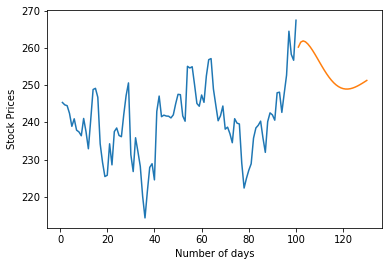

In [33]:
plt.plot(day_new,scaler.inverse_transform(df1[(len(df1)-time_step):]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.ylabel('Stock Prices')
plt.xlabel('Number of days')

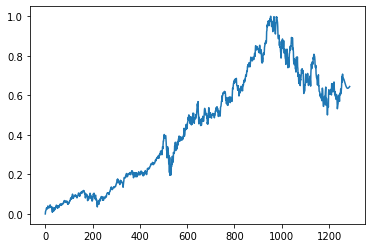

In [34]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3)

In [35]:
df3=scaler.inverse_transform(df3).tolist()

Text(0.5, 0, 'Number of days')

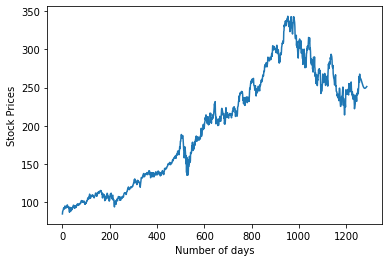

In [36]:
plt.plot(df3)
plt.ylabel('Stock Prices')
plt.xlabel('Number of days')